# Notes
- This notebooks serves to generate a csv that will be imported to TrackMate
- Csv will contain information about predictions (coordinates, quality , radius, etc)
- Detection is done using a specified model; this model is loaded in the cell "Load Trained Model"

In [1]:
import sys,os
import pandas as pd

ROOT_DIR = os.path.abspath( '..' )
DATA_DIR = os.path.join( ROOT_DIR, 'data' )

# # training dataset 
# DATA_RAW_DIR = os.path.join( DATA_DIR, '1_icy-benchmark-training_set' )
# DATA_GEN_DIR = os.path.join(DATA_DIR, '2_generated_from_icy_benchmark_set' )

# test dataset
DATA_TEST_DIR = os.path.join(DATA_DIR, '2_generated_from_official_set' )
IMAGES_DIR = os.path.join( DATA_TEST_DIR, 'images' )
MASKS_DIR = os.path.join( DATA_TEST_DIR, 'masks' )

MODELS_DIR = os.path.join(ROOT_DIR, 'models' )

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


# Data
- Load only test data; Pay attention to the data that you used for training; dont use it in testing mode.

In [3]:
files = os.listdir(IMAGES_DIR) 
tifs = [f for f in files if 'tif' in f]
tifs.sort()

# the naming should be identical; the abs paths to the images (X) and the masks (Y):
imgs = [os.path.join(IMAGES_DIR, t) for t in tifs]
lbls = [os.path.join(MASKS_DIR, t) for t in tifs]

inds_all = np.arange(0, len(imgs))
inds_test = inds_all

X_te = [imgs[i] for i in inds_all]
Y_te = [lbls[i] for i in inds_all]

# loading:
X_te = list(map(imread, X_te))
Y_te = list(map(imread, Y_te))

print('Loaded %d images'%len(X_te))

Loaded 3900 images


In [4]:
# stardist related inputs
n_channel = 1 #if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)

# Load trained model

In [5]:
model_name = 'mixAll'
model = StarDist2D(None, name='stardist', basedir=os.path.join(MODELS_DIR, model_name) )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.475881, nms_thresh=0.4.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

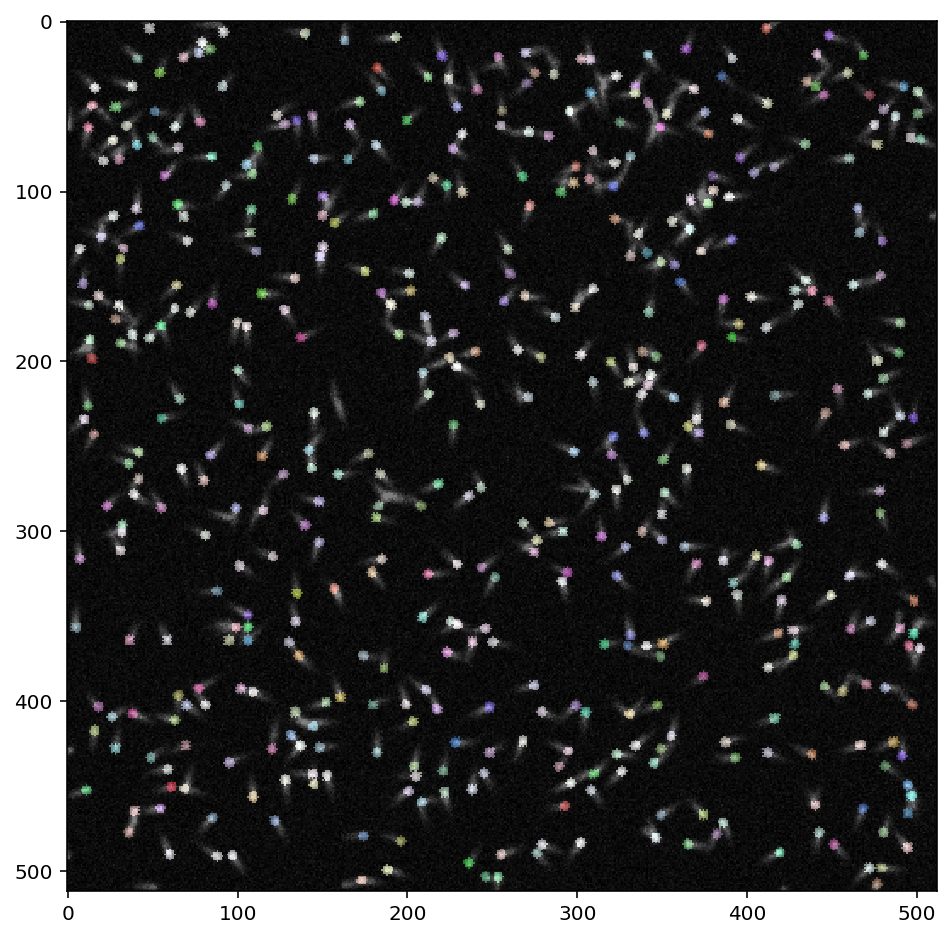

In [6]:
_ind = 900
_img = imread( imgs[_ind] )
img = normalize( _img, 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
# plt.axis('off');

In [7]:
i = 900
imgs[i], lbls[i]

('/master/home/dershov/Development/DL/stardist-trackmate/data/2_generated_from_official_set/images/MICROTUBULE snr 7 density high_00000.tif',
 '/master/home/dershov/Development/DL/stardist-trackmate/data/2_generated_from_official_set/masks/MICROTUBULE snr 7 density high_00000.tif')

## Do all predictions -> CSV


In [9]:
# ID, frame, X, Y, Z, radius, quality
df_img_names = []
df_ids = []
df_frames = []
df_x = []
df_y = []
df_z = []
df_radii = []
df_probs = []

print('Total test images: %d'%len(X_te))

for img_ind, img_path in enumerate(imgs):
    
    if img_ind%10==0: print(img_ind, end=',')
        
    img_name = os.path.basename(img_path).replace('.tif','')
    fr = int(img_name.split('_')[-1])
    img = imread(img_path)

    # predict, get data
    img = normalize(img, 1, 99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)
    coords_rc = details['coord']
    points_rc = details['points']
    probs = details['prob']
    
    _id = 0
    for _coords_rc, _rc, _prob in zip(coords_rc, points_rc, probs ):
        
        # calculate avg radius from all the rays:
        dydx = _coords_rc.T - _rc
        _ravg = np.sqrt((dydx**2).sum(axis=1)).mean()

        # centroid as integer or as float (from rays)
        # _y,_x =_rc
        _y, _x = _coords_rc.T.mean(axis=0)

        
        df_img_names.append(img_name)
        df_frames.append(fr)
        df_ids.append(_id)
        df_x.append(_x)
        df_y.append(_y)
        df_z.append(0.)
        df_radii.append(_ravg)
        df_probs.append(_prob)
        _id += 1

        
# ID, frame, X, Y, Z, radius, quality
df = pd.DataFrame( data={'img_name':df_img_names,
                        'ID':df_ids,
                        'frame':df_frames,
                        'X':df_x,
                        'Y':df_y,
                        'Z':df_z,
                        'radius':df_radii,
                         'quality':df_probs}  )
print('\nDone.')

Total test images: 3900
0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000,1010,1020,1030,1040,1050,1060,1070,1080,1090,1100,1110,1120,1130,1140,1150,1160,1170,1180,1190,1200,1210,1220,1230,1240,1250,1260,1270,1280,1290,1300,1310,1320,1330,1340,1350,1360,1370,1380,1390,1400,1410,1420,1430,1440,1450,1460,1470,1480,1490,1500,1510,1520,1530,1540,1550,1560,1570,1580,1590,1600,1610,1620,1630,1640,1650,1660,1670,1680,1690,1700,1710,1720,1730,1740,1750,1760,1770,1780,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100,2110,2120,2130,2140,2150,2160,21

# Save CSV file.
- pay attention to the model name
- pay attention to the subset patterns (e.g. "VESICLE").

In [10]:
df.to_csv(os.path.join(DATA_DIR, 'model[%s]_predictions.csv'%model_name), index=False)